# Image Self-Supervised Learning with pytorch lightning

In [2]:
!pip install pytorch-lightning

     |████████████████████████████████| 829kB 5.8MB/s 
     |████████████████████████████████| 276kB 33.8MB/s 
     |████████████████████████████████| 829kB 33.6MB/s 
     |████████████████████████████████| 112kB 37.4MB/s 
     |████████████████████████████████| 1.3MB 38.2MB/s 
     |████████████████████████████████| 296kB 39.9MB/s 
     |████████████████████████████████| 143kB 29.1MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=d48d0764bfb3222a3ecc38ca6f9ce27b8ab6c4fc5d4a3e6b2d6c456f8ab37446
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=ce89d8d3ddadcad763e2be9414e9caab0ccaac64884b13206a156d32d4db1cda
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    U

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from PIL import Image
from pathlib import Path
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

In [4]:
# For Dataset, we're going to use a smaller version of ImageNet called Imagenette. This dataset contains images from 10 classes of the larger set

In [5]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar xvzf imagenette2-320.tgz

Streaming output truncated to the last 5000 lines.
imagenette2-320/train/n03888257/n03888257_16077.JPEG
imagenette2-320/train/n03888257/n03888257_23339.JPEG
imagenette2-320/train/n03888257/n03888257_44204.JPEG
imagenette2-320/train/n03888257/n03888257_61633.JPEG
imagenette2-320/train/n03888257/n03888257_15067.JPEG
imagenette2-320/train/n03888257/n03888257_75365.JPEG
imagenette2-320/train/n03888257/n03888257_63966.JPEG
imagenette2-320/train/n03888257/n03888257_3927.JPEG
imagenette2-320/train/n03888257/n03888257_20684.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-320/train/n03888257/n03888257_14016.JPEG
imagenette2-320/train/n03888257/n03888257_37776.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-320/train/n03888257/n03888257_17513.JPEG
imagenette2-320/train/n03888257/n03888257_17143.JPEG
imagenette2-320/train/n03888257/n03888257_6738.JPEG
imagenette2-320/train/n03888257/n03888257_4355.JPEG
imagenette2-320/train/n03888257/ILS

# Automatically labelling the data with Input Augmentation and Reconstruction

In [6]:
# Even though we're using PyTorch Lightning, we'll construct our datasets in the usual way with the Dataset class. When an image is requested from the dataset, 
# we will either simply return a tensor version of the image with the label 0, or 
# randomly apply a rotational transform through 90, 180, or 270 degrees, or flipping the image's axis either horizontally or vertically. 
# Each of these potential transforms has a separate label, giving us six potential labels for any image.


class RotationalTransform:  #Rotating the Image based on input angle and Image flipping
  def __init__(self, angle):
    self.angle = angle

  def __call__(self, x):
    return TF.rotate(x, self.angle)

class VerticalFlip:
  def __init__(self):
    pass
  def __call__(self, x):
    return TF.vflip(x)

class HorizontalFlip:
  def __init__(self):
    pass
  def __call__(self, x):
    return TF.hflip(x)

In [7]:
# We'll then wrap those transforms up inside a `Dataset` class, which will apply a chosen transformation when `__getitem__` 
# is called, as well as returning the correct label for that transform.  


class SelfSupervisedDataset(object):   
  def __init__(self, image_path=Path("imagenette2-320/train")):
    self.imgs = list(image_path.glob('**/*.JPEG'))
    self.class_transforms = [RotationalTransform(0), RotationalTransform(90), 
                       RotationalTransform(180), RotationalTransform(270), 
                       HorizontalFlip(),VerticalFlip()]
    self.to_tensor = transforms.Compose([transforms.ToTensor()])                       
    self.classes = len(self.class_transforms)

  def __getitem__(self, idx):
    img = Image.open(self.imgs[idx])
    label = random.choice(range(0, self.classes))
    img = img.convert("RGB")
    # Resize first, then apply our selected transform and finally convert to tensor
    transformed_image = self.to_tensor(self.class_transforms[label](transforms.Resize((224,224))(img)))
    return transformed_image, label

  def __len__(self):
    return len(self.imgs)

In [37]:
# Our selfSupervisedModel here is resnet50 with custom head. We are going to download resnet34 model from torchvision.models without pretraining.
# PyTorch Lightning includes hooks for lots of other parts of the training process

class SelfSupervisedModel(pl.LightningModule):
   
  def __init__(self, hparams=None, num_classes=6, batch_size=64):   #num_classes=6 since each of the potential transforms of the input img gives six potential labels
    super(SelfSupervisedModel, self).__init__()
    self.resnet = torchvision.models.resnet34(pretrained=False)
    self.resnet.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, num_classes))
    self.batch_size = batch_size
    self.loss_fn = nn.CrossEntropyLoss()
    if "lr" not in hparams:
      hparams["lr"] = 0.001
    self.hparams = hparams

  def forward(self, x):
    return self.resnet(x)

  def training_step(self, batch, batch_idx):
    inputs, targets = batch
    predictions = self(inputs)
    loss = self.loss_fn(predictions, targets)
    return {'loss': loss}

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

  def prepare_data(self):
    self.training_dataset = SelfSupervisedDataset()
    self.val_dataset = SelfSupervisedDataset(Path("imagenette2-320/val"))
    
  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.training_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)

  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

  def validation_step(self, batch, batch_idx):
    inputs, targets = batch
    predictions = self(inputs)
    val_loss = self.loss_fn(predictions, targets)
    _, preds = torch.max(predictions, 1)
    acc = torch.sum(preds == targets.data) / (targets.shape[0] * 1.0)
    return {'val_loss': val_loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):  # update statistics for loss and accuracy in our validation set at the end of every epoch.
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    avg_acc = torch.stack([x['val_acc'].float() for x in outputs]).mean()
    logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
    return {'progress_bar': logs}

In [9]:
model = SelfSupervisedModel({'lr': 0.001})

trainer = pl.Trainer(max_epochs=15, gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type             | Params
---------------------------------------------
0 | resnet  | ResNet           | 21.4 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.670    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [23]:
trainer = pl.Trainer(max_epochs=8, gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type             | Params
---------------------------------------------
0 | resnet  | ResNet           | 21.4 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.674    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [36]:
trainer.save_checkpoint("selfsupervised1.pth")  

In [38]:
model = SelfSupervisedModel({'lr': 0.001})

In [39]:
model = model.load_from_checkpoint("selfsupervised1.pth")   #Loading the model from saved checkpoint
model

SelfSupervisedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [40]:
# our model needs to determine ImageNet class an image belongs to.
# Inorder to do that we are going to replace the current dataloader with dataloaders for 
# ones that returns the images and the labels for the provided Imagenette dataset. We do this using "ImageFolder"


tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

In [41]:
imagenette_training_data = torchvision.datasets.ImageFolder(root="imagenette2-320/train/", transform=tfms)
imagenette_training_data_loader = torch.utils.data.DataLoader(imagenette_training_data, batch_size=64, num_workers=4, shuffle=True)

imagenette_val_data = torchvision.datasets.ImageFolder(root="imagenette2-320/val/", transform=tfms)
imagenette_val_data_loader = torch.utils.data.DataLoader(imagenette_val_data, batch_size=64, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [42]:
imagenette_training_data.__getitem__(4000)

(tensor([[[0.0039, 0.0000, 0.0196,  ..., 0.0392, 0.0039, 0.0000],
          [0.0392, 0.0275, 0.0392,  ..., 0.0235, 0.0039, 0.0000],
          [0.0431, 0.0549, 0.0667,  ..., 0.0667, 0.0039, 0.0000],
          ...,
          [0.0275, 0.0745, 0.0314,  ..., 0.0784, 0.0000, 0.0000],
          [0.0235, 0.0549, 0.0118,  ..., 0.0275, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0000,  ..., 0.0353, 0.0000, 0.0000]],
 
         [[0.0275, 0.0275, 0.0157,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0118, 0.0039, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0078, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
          [0.0353, 0.0157, 0.0275,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0118, 0.0039, 0.0118,  ..., 0.0039, 0.0039, 0.0000],
          [0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0039, 0.0000],
          [0.0078, 0.0157, 0.0196,  ...,

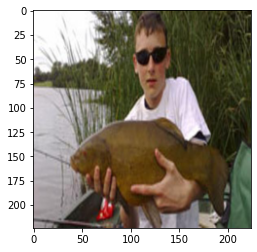

In [43]:
import matplotlib.pyplot as plt


img, label = imagenette_training_data[116]
plt.imshow(img.permute(1, 2, 0))


In [44]:
imagenette_training_data.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [18]:
# We'll then load in our saved checkpoint, replacing the original training data with the new DataLoader, and 
# we'll replace the head of the classifier so it now is predicting the 10 ImageNet labels instead of our self-supervised labels. 
# The model will be trained for a further 5 epochs on the supervised training data.

In [19]:
model = model.load_from_checkpoint("selfsupervised.pth")

model.resnet.fc[2] = nn.Linear(256,10)

In [45]:
trainer = pl.Trainer(max_epochs=15, gpus=1)
trainer.fit(model, train_dataloader=imagenette_training_data_loader, val_dataloaders=imagenette_val_data_loader) #training with new dataloaders 

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type             | Params
---------------------------------------------
0 | resnet  | ResNet           | 21.4 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.674    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [46]:
device = torch.device("cuda")
model.to(device)

SelfSupervisedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [47]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in imagenette_val_data_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
print('Accuracy: %d %%' % (100 * correct/total))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 73 %


 We got an accuracy of 73% within 15 EPOCHS!!! 
 Pre-training with our self-supervised dataset offers a greater performance despite being trained on the final task for only 15 epochs. 

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [59]:
model_save_name = 'self-supervised_classifier12.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)